<a href="https://colab.research.google.com/github/Zuhair0000/fine_tuning_course/blob/main/fine_tuning_BERT_for_multi_class_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/twitter_multi_class_sentiment.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [3]:
df.isnull().sum()

,0
text,0
label,0
label_name,0


In [4]:
df.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [5]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frequency of classes')

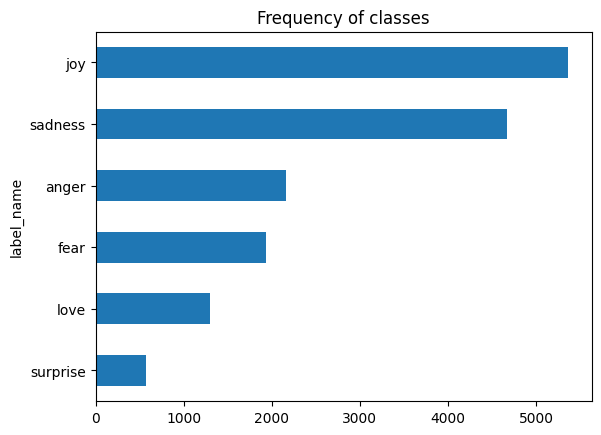

In [6]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of classes")

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

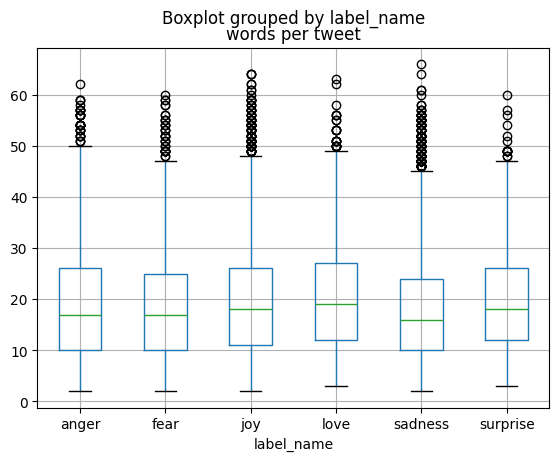

In [7]:
df['words per tweet'] = df['text'].str.split().apply(len)
df.boxplot('words per tweet', by='label_name')

In [8]:
df.head()

,text,label,label_name,words per tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


In [10]:
from transformers import AutoTokenizer

model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = 'I love machine learning! Tokenizatoin is awesome'

encode_text = tokenizer(text)
print((encode_text))

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 21335, 3406, 2378, 2003, 12476, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
tokenizer.vocab_size

30522

# Data Loader and Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

# **Converting to Hugging Face Format**
Pandas is great for humans, but Hugging Face models prefer their own Dataset object format because it's faster for training.


1. Dataset.from_pandas: Converts the Pandas DataFrame into a Hugging Face Dataset.

2. preserve_index=False: Pandas creates a numbered index (0, 1, 2...) on the left. We don't need this extra column cluttering our AI data, so we throw it away.

3. DatasetDict: A container that holds all three splits (train, test, validation) in one variable, making it easy to access them later (e.g., dataset['train']).



In [15]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train': Dataset.from_pandas(train, preserve_index=False),
     'test': Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 1600
    })
})

In [17]:
dataset['train'][0]

{'text': 'i feel cute i feel good',
 'label': 1,
 'label_name': 'joy',
 'words per tweet': 6}

# Tokenization

In [18]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2514, 10140, 1045, 2514, 2204, 102, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2514, 2200, 10190, 1998, 5341, 2000, 2031, 2179, 1037, 2995, 2214, 3969, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [21]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [22]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [24]:
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k, v in label2id.items()}

label2id, id2label

({'joy': 1, 'surprise': 5, 'fear': 4, 'sadness': 0, 'anger': 3, 'love': 2},
 {1: 'joy', 5: 'surprise', 4: 'fear', 0: 'sadness', 3: 'anger', 2: 'love'})